In [1]:
import sys
import model as model
import visualization as visualization
import evaluate as evaluate
import data as data

import numpy as np
#import pandas as pd

In [2]:
#RUN ONLY TO SAVE IMAGES LOCALLY

# data.save_imgs_2npy(meta_path='data/meta',
#             mk_folder_path='data/C02-MK/2020',
#             img_folder_path='data/C02-FR/2020',
#             destintation_path='data/images',
#             split_days_into_folders=True
#     )

In [2]:
#LOAD WHOLE DAY
images_20, timestamp_20 = data.load_images_from_folder('data/images/dia_20',cutUruguay = True)

In [4]:
#TEST model.persitence RETURN
predictions, predict_ts = model.persitence(images_20[80], timestamp_20[80], predict_horizon = 5)
print('persistence returned', len(predictions), 'images')
print('timestamp of input image',timestamp_20[80])
print('timestamp of predicted images', predict_ts)

persistence returned 5 images
timestamp of input image 2020-01-20 13:20:17
timestamp of predicted images DatetimeIndex(['2020-01-20 13:30:17', '2020-01-20 13:40:17',
               '2020-01-20 13:50:17', '2020-01-20 14:00:17',
               '2020-01-20 14:10:17'],
              dtype='datetime64[ns]', freq='10T')


In [5]:
#TEST evaluate.evaluate_image RETURN

predict_itself = evaluate.evaluate_image(predictions[0], images_20[80], metric='PSNR',  pixel_max_value =255) 
predict_errors = evaluate.evaluate_image(predictions, images_20[81:86], metric='PSNR',  pixel_max_value =255)
print('error comparing with same image', predict_itself)
print('error comparing with next images in ground truth' , predict_errors)

error comparing with same image [48.1308036086791]
error comparing with next images in ground truth [25.78515217138746, 23.85625395914225, 22.762198101362976, 22.145509987881354, 21.85083603009314]


In [4]:
#ERROR CALCULATOR WHEN WHOLE DAY LOADED

predict_horizon = 10
error_p_list =[] #used for persistence
error_bp_list =[] #used for blurred persistence

for i in range(len(images_20)):
    if (i < len(images_20)-predict_horizon):
        predictions_p, _ = model.persitence(images_20[i], timestamp_20[i], predict_horizon)
        predictions_bp, _ = model.blurred_persitence(images_20[i], timestamp_20[i], predict_horizon,kernel_size=(11,11))
        
        predict_errors_p = evaluate.evaluate_image(predictions_p, images_20[i+1:i+predict_horizon+1], 
                                                metric='RMSE',  pixel_max_value =255)
        predict_errors_bp = evaluate.evaluate_image(predictions_bp, images_20[i+1:i+predict_horizon+1], 
                                                metric='RMSE',  pixel_max_value =255)
        
    else: #starts predicting images outside the day
        
        predictions_p, _ = model.persitence(images_20[i], timestamp_20[i], len(images_20)-(i+1))
        predictions_bp, _ = model.blurred_persitence(images_20[i], timestamp_20[i], len(images_20)-(i+1),kernel_size=(11,11))
        
        predict_errors_p = evaluate.evaluate_image(predictions_p, images_20[i+1:], 
                                                metric='RMSE',  pixel_max_value =255)
        predict_errors_bp = evaluate.evaluate_image(predictions_bp, images_20[i+1:], 
                                                metric='RMSE',  pixel_max_value =255)
        
        for _ in range(predict_horizon+1 - (len(images_20)-i)):
            #puts 0 in errors for predictions outside the day
            predict_errors_p.append(0)
            predict_errors_bp.append(0)
        
    error_p_list.append(predict_errors_p)
    error_bp_list.append(predict_errors_bp)
    
    
print('Predicted for',len(error_p_list), 'images')

error_p_array = np.array(error_p_list)
error_bp_array = np.array(error_bp_list)

print(error_p_array.shape)
    

Predicted for 144 images
(144, 10)


In [4]:
#Testing for batch loading . Not working yet

current_imgs = []
predict_horizon = 10
files_total = len(os.listdir('data/images/dia_20'))

time_stamp = []
error_p_list = []

current_imgs, time_stamp, last_img_filename = data.load_by_batches(folder='data/images/dia_20', 
                                                          current_imgs=current_imgs, 
                                                          time_stamp= time_stamp, 
                                                          list_size= predict_horizon + 1, 
                                                          last_img_filename= None)

predictions_p, _ = model.persitence(current_imgs[0], time_stamp[0], predict_horizon)
predict_errors_p = evaluate.evaluate_image(predictions_p, current_imgs[1:], metric='RMSE')

error_p_list.append(predict_errors_p)

for _ in range():
    
    
    current_imgs, time_stamp, last_img_filename = data.load_by_batches(folder='data/images/dia_20', 
                                                            current_imgs=current_imgs, 
                                                            time_stamp= time_stamp, 
                                                            list_size= predict_horizon + 1, 
                                                            last_img_filename= last_img_filename)

11
[datetime.datetime(2020, 1, 20, 0, 0, 17), datetime.datetime(2020, 1, 20, 0, 10, 17), datetime.datetime(2020, 1, 20, 0, 20, 17), datetime.datetime(2020, 1, 20, 0, 30, 17), datetime.datetime(2020, 1, 20, 0, 40, 17), datetime.datetime(2020, 1, 20, 0, 50, 17), datetime.datetime(2020, 1, 20, 1, 0, 17), datetime.datetime(2020, 1, 20, 1, 10, 17), datetime.datetime(2020, 1, 20, 1, 20, 17), datetime.datetime(2020, 1, 20, 1, 30, 17), datetime.datetime(2020, 1, 20, 1, 40, 17)]
ART_2020020_014017.npy


In [13]:
visualization.save_errorarray_as_csv(error_p_array,timestamp_20, 'prueba')

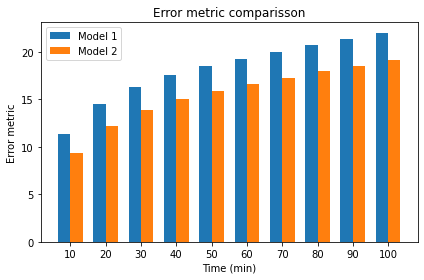

In [7]:
#Slice day in 70:100 to leave night time out

mean_error_p = np.mean(error_p_array[70:100],axis=0)
mean_error_bp = np.mean(error_bp_array[70:100],axis=0)

visualization.barchart_compare(mean_error_p,mean_error_bp)

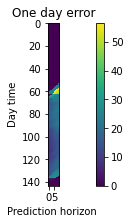

In [15]:
visualization.matrix_graph(error_p_array)
#visualization.matrix_graph(error_gp_array)

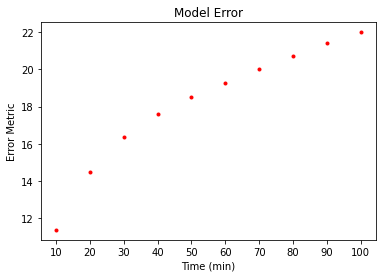

In [16]:
visualization.plot_graph(mean_error_p)